In [36]:
import torch

import pdb


def build_K_batch(tx, cx, mx, x, tq, cq, mq, C):
    """
    convert the data into a format suitable for the conditional module
    tx: Tensor - Time points of the observations.
    cx: Tensor - Channel ID for the observations.
    mx: Tensor - Mask for the observations.
    x: Tensor - Observed values.
    tq: Tensor - Time points for the query.
    cq: Tensor - Channel ID for the query.
    mq: Tensor - Mask for the query.
    C: int - Number of channels.

    Returns:
    K: Tensor - Processed observations in the form of a batch matrix.
    M: Tensor - Mask for the observations.
    Mq: Tensor - Mask for the query.
    unique_Ts: Tensor - Unique time points both observed and query for each batch.
    """

    batch_size = tx.shape[0]

    if (
        tx.shape[1] != cx.shape[1]
        or tx.shape[1] != mx.shape[1]
        or tx.shape[1] != x.shape[1]
    ):
        raise ValueError(
            "Time, channel, mask, and value tensors must have the same second dimension."
        )
    if tq.shape[1] != cq.shape[1] or tq.shape[1] != mq.shape[1]:
        raise ValueError(
            "Query time, channel, and mask tensors must have the same second dimension."
        )

    # --- mask valid entries ---

    mask_total = torch.cat(
        [mx, mq], dim=1
    ).bool()  # combined mask for both observations and queries
    time_total = torch.cat([tx, tq], dim=1)  # combined time points
    channel_total = torch.cat(
        [cx, cq], dim=1
    )  # combined channel IDs for both observations and queries
    value_total = torch.cat([x, torch.zeros_like(tq)], dim=1)  # combined values
    obs_mask = torch.cat(
        [mx, torch.zeros_like(mq)], dim=1
    )  # mask for observations dimension extended for queries as well
    qry_mask = torch.cat([torch.zeros_like(mx), mq], dim=1)  # mask for queries
    T, D, V, Mobs, Mq = (
        time_total[mask_total],
        channel_total[mask_total],
        value_total[mask_total],
        obs_mask[mask_total],
        qry_mask[mask_total],
    )  # Extract valid entries based on the combined mask

    batch_valid = torch.arange(batch_size, device=tx.device).repeat_interleave(
        mask_total.sum(1)
    )  # Batch indices for valid entries

    # --- offset trick to separate batches ---
    t_max = T.max().item() + 1  # Maximum time value + 1 to avoid overlap
    t_off = T + batch_valid * t_max  # Offset time points to separate batches
    unique_t_off, inverse = torch.unique(
        t_off, sorted=True, return_inverse=True
    )  # Unique time points with offsets

    unique_b = unique_t_off // t_max  # which batch each unique belongs to
    unique_t = unique_t_off % t_max  # actual time values

    # number of unique times per batch
    n_per_batch = torch.bincount(unique_b, minlength=batch_size)
    n_max = int(n_per_batch.max())

    # --- compute row_idx for each entry (for K) ---
    cumsum = torch.zeros(batch_size + 1, device=tx.device, dtype=torch.long)
    cumsum[1:] = torch.cumsum(n_per_batch, 0)
    row_idx = inverse - cumsum[batch_valid]  # per-entry row index

    # --- build K with accumulation ---
    k = torch.zeros((batch_size, n_max, C), dtype=x.dtype, device=x.device)
    k.index_put_((batch_valid, row_idx, D), V, accumulate=True)

    # --- build mask with accumulation ---
    mobs = torch.zeros((batch_size, n_max, C), dtype=x.dtype, device=x.device)
    mobs.index_put_((batch_valid, row_idx, D), Mobs.to(torch.float32), accumulate=True)

    mq = torch.zeros((batch_size, n_max, C), dtype=x.dtype, device=x.device)
    mq.index_put_((batch_valid, row_idx, D), Mq.to(torch.float32), accumulate=True)

    # --- compute row_idx_u for uniques (for unique_Ts) ---
    # basically 0..N_per_batch[b]-1 for each batch
    row_idx_u = torch.arange(unique_t.shape[0], device=tx.device) - cumsum[unique_b]

    # --- build unique_Ts ---
    unique_ts = torch.zeros((batch_size, n_max), dtype=tx.dtype, device=tx.device)
    unique_ts[unique_b, row_idx_u] = unique_t

    return k, mobs, mq, unique_ts


tx = torch.tensor([[1, 2, 2, 3, 0, 0], [5, 5, 7, 0, 0, 0], [1, 2, 3, 4, 5, 6]])
cx = torch.tensor([[0, 0, 2, 0, 0, 0], [1, 2, 1, 0, 0, 0], [2, 2, 2, 2, 2, 2]])
mx = torch.tensor([[1, 1, 1, 1, 0, 0], [1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1]])
x = torch.tensor(
    [
        [10.0, 20.0, 30.0, 40.0, 0.0, 0.0],
        [50.0, 60.0, 70.0, 0.0, 0.0, 0.0],
        [80.0, 90.0, 100.0, 110.0, 120.0, 130.0],
    ]
)

tq = torch.tensor([[4, 5, 0], [8, 8, 12], [8, 9, 10]])
cq = torch.tensor([[0, 0, 0], [1, 2, 1], [2, 2, 2]])
mq = torch.tensor([[1, 1, 0], [1, 1, 1], [1, 1, 1]])

C = 4
k, mobs, mq, unique_ts = build_K_batch(tx, cx, mx, x, tq, cq, mq, C)
print("Unique timepoints per batch:\n", unique_ts)
print("K:\n", k)
print("Mobs:\n", mobs)
print("Mq:\n", mq)


Unique timepoints per batch:
 tensor([[ 1,  2,  3,  4,  5,  0,  0,  0,  0],
        [ 5,  7,  8, 12,  0,  0,  0,  0,  0],
        [ 1,  2,  3,  4,  5,  6,  8,  9, 10]])
K:
 tensor([[[ 10.,   0.,   0.,   0.],
         [ 20.,   0.,  30.,   0.],
         [ 40.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.]],

        [[  0.,  50.,  60.,   0.],
         [  0.,  70.,   0.,   0.],
         [  0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.]],

        [[  0.,   0.,  80.,   0.],
         [  0.,   0.,  90.,   0.],
         [  0.,   0., 100.,   0.],
         [  0.,   0., 110.,   0.],
         [  0.,   0., 120.,   0.],
         [  0.,   

In [87]:
import numpy as np
def shiesh_(x,a=1,t=1):
    """
    Shiesh activation function.
    
    Args:
        x (Tensor): Input tensor.
        a (float): Scaling factor.
        t (float): Translation factor.
    
    Returns:
        Tensor: Activated tensor.
    """
    return 1/a * np.arcsinh(np.exp(a*t)*np.sinh(a*x))

In [166]:
import math
import torch
import torch.nn.functional as F
def shiesh_jac(x,a=1,t=1):
    """
    Computes the log-Jacobian determinant for a transformation
    in a numerically stable and efficient way.
    """
    ax = a * x
    slope = math.exp(a * t)
    log_slope = a*t

    # log(cosh(ax)) is safe directly since |ax| <= 5
    log_cosh_ax = torch.log(torch.cosh(ax))

    # sinh(ax) is also stable in this range
    sinh_ax = torch.sinh(ax)

    # log(1 + slope^2 * sinh^2(ax))
    log_denominator = 0.5 * torch.log1p((slope * sinh_ax) ** 2)

    # numerator = e^{at}*cosh(ax)
    log_numerator = log_slope + log_cosh_ax

    return log_numerator - log_denominator

In [64]:
x = np.array([0, 1])
y = shiesh(x, a=1, t=1)
ldj = shiesh_log_jac(x, a=1, t=1)
np_ldj = np.log(np.gradient(y))
# plt.plot(x, ldj - np_ldj, label='Shiesh Activation')
print(ldj, np_ldj)

[1.         0.22560035] [0.63032993 0.63032993]


In [85]:
from sympy import symbols, diff, asinh, cosh, sinh, log, exp

x = symbols('x')
a = symbols('a')
t = symbols('t')
shiesh_expr = 1/a * asinh(exp(a*t) * sinh(a*x))
shiesh_derivative = log(diff(shiesh_expr, x))
shiesh_derivative_simplified = shiesh_derivative.simplify()
print(f"Shiesh derivative: {shiesh_derivative}")
print(f"Simplified Shiesh derivative: {shiesh_derivative_simplified}")

Shiesh derivative: log(exp(a*t)*cosh(a*x)/sqrt(exp(2*a*t)*sinh(a*x)**2 + 1))
Simplified Shiesh derivative: log(exp(a*t)*cosh(a*x)/sqrt(exp(2*a*t)*sinh(a*x)**2 + 1))


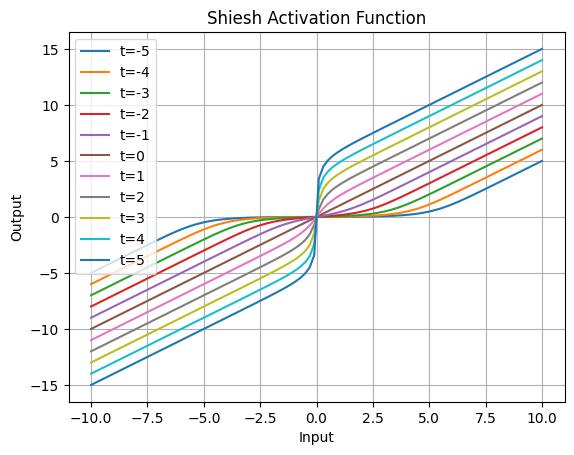

In [83]:
import matplotlib.pyplot as plt
for t in [-5,-4,-3,-2,-1,0,1,2,3,4,5]:
    x = np.linspace(-10, 10, 100)
    y = shiesh_(x, a=1, t=t)
    plt.plot(x, y, label=f't={t}')
plt.title("Shiesh Activation Function")
plt.xlabel("Input")
plt.ylabel("Output")
plt.legend()
plt.grid()
plt.show()

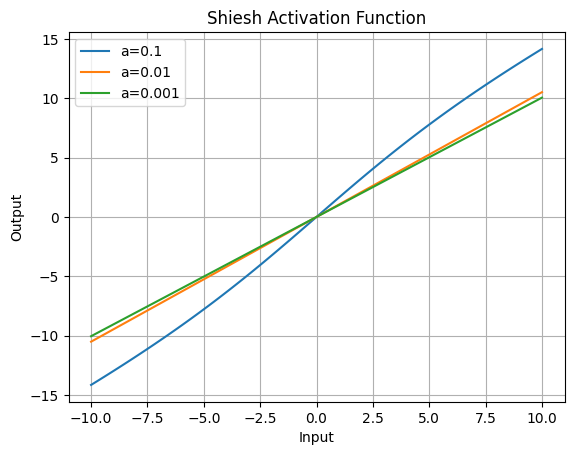

In [84]:
import matplotlib.pyplot as plt
for a in [0.1,0.01,0.001]:
    x = np.linspace(-10, 10, 100)
    y = shiesh_(x, a=a, t=5)
    plt.plot(x, y, label=f'a={a}')
plt.title("Shiesh Activation Function")
plt.xlabel("Input")
plt.ylabel("Output")
plt.legend()
plt.grid()
plt.show()

Shiesh Activation Output: tensor([-501.0000, -500.8000, -500.5999,  ...,  500.5999,  500.8000,
         501.0000], grad_fn=<WhereBackward0>)
NumPy Log Jacobian: tensor([nan, nan, nan,  ..., nan, nan, nan]) tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<WhereBackward0>) tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<WhereBackward0>)


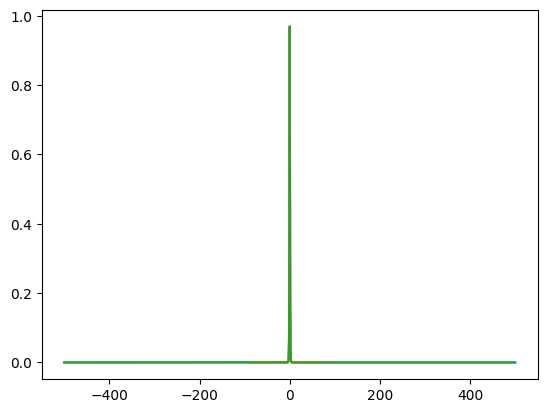

In [170]:
import torch
import shiesh
import numpy as np


x = torch.linspace(-500,500,5000, requires_grad=True)

large_inds = torch.abs(x) > 5
        # Mask out large values before applying shiesh_log_jac
safe_x = torch.where(large_inds, torch.zeros_like(x), x)



a = 1.0
t = 1.0
activation = shiesh.Shiesh(a=a, t=t)

y, shiesh_ldj = activation(x)

ldj = torch.where(
    large_inds,
    0.0,  # Logarithmic Jacobian is zero for the linear part
    shiesh_jac(safe_x,a,t),
)
# ldj = shiesh_jac(x, a=1.0, t=1.0)
y.sum().backward()
np_ldj = x.grad
# dldj = ldj.sum().backward()
# plt.plot(x.detach().numpy(), x.grad.detach().numpy(), label='Shiesh Activation Gradient')

plt.plot(x.detach().numpy(), ldj.detach().numpy(), label='Shiesh Log Jacobian')
plt.plot(x.detach().numpy(), torch.log(np_ldj).detach().numpy(), label='Shiesh Log Jacobian autodif')
plt.plot(x.detach().numpy(), shiesh_ldj.detach().numpy(), label='Shiesh Log Jacobian from function')
print("Shiesh Activation Output:", y)
# print("Log Jacobian:", ldj)
print("NumPy Log Jacobian:", torch.log(np_ldj), ldj, shiesh_ldj)


In [ ]:
class EnergyScore(nn.Module):
    def __init__(self, beta: float = 1.0):
        super().__init__()
        self.beta = beta

    def forward(self, y, yhat, mask=None):
        """
        y: [batch, dim]
        yhat: [batch, nsamples, dim]
        mask: optional, [batch, dim]
        """
        batch_size, nsamples, dim = yhat.shape

        if mask is not None:
            valid_batch = mask.sum(dim=1) > 0
            y = y[valid_batch] * mask[valid_batch]
            yhat = yhat[valid_batch] * mask[valid_batch, None, :]
        else:
            valid_batch = torch.ones(batch_size, dtype=torch.bool, device=y.device)

        # First term: mean over samples
        diff = torch.cdist(yhat, y[:, None, :], p=2)  # [batch, nsamples, 1]
        first_term = diff.pow(self.beta).mean(dim=1).squeeze(-1)  # mean over nsamples

        # Second term: pairwise distances, exclude diagonal
        pairwise = torch.cdist(yhat, yhat, p=2)
        diag = torch.diagonal(pairwise, dim1=1, dim2=2)
        pairwise = pairwise - torch.diag_embed(diag)
        second_term = - pairwise.pow(self.beta).sum(dim=(1,2)) / (2 * nsamples**2)

        energy = first_term + second_term
        return energy  # per batch


In [202]:
import scoringrules as sr
import torch

torch.manual_seed(0)
y = torch.tensor([[1.0, 2.0],
                  [3.0, 4.0],
                  [5.0, 6.0]])

yhat = torch.tensor([
    [[0.9, 2.1], [1.0, 2.0], [1.1, 1.9], [0.8, 2.2], [1.0, 2.1]],
    [[3.1, 3.9], [3.0, 4.0], [2.9, 4.1], [3.2, 3.8], [3.0, 4.1]],
    [[5.1, 6.1], [4.9, 5.9], [5.0, 6.0], [5.2, 6.2], [4.8, 5.8]]
])

energy_fn = EnergyScore(beta=1.0)
score_torch = energy_fn(y, yhat)

score_sr = sr.energy_score(y.numpy(), yhat.numpy())

print("PyTorch Energy Score:", score_torch)
print("scoringrules Energy Score:", score_sr)


PyTorch Energy Score: tensor([0.0507, 0.0452, 0.0566])
scoringrules Energy Score: [0.05067997 0.04520204 0.0565685 ]


In [176]:
print(y.shape, yhat.shape)

torch.Size([3, 2]) torch.Size([3, 5, 2])
